In [3]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import datetime

########## INPUT #############
# it = int(sys.argv[1])-1
# f_varlist = Path(sys.argv[2])
# job_id = sys.argv[3]

it=0
f_varlist = Path('../data/PriorModel/varlist.pkl')
job_id='test'
print(it,f_varlist)

########## INPUT #############


if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

import config
import utils


#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))



if len(f_varlist.name.split('.'))>1:
    nam = f_varlist.name.split('.')[0]
else:
    nam = f_varlist.name
varlist = load_obj(f_varlist.parent,nam)
ts = make_timestamp()

print('loading...')
##Loading
modelname = 'NM'
model_ws = workdir.joinpath('NM_{}'.format(it))
m= flopy.seawat.Seawat.load(modelname + '.nam',exe_name=config.swexe, model_ws=model_ws.as_posix())
rows = np.load(model_ws.joinpath('rows.npy'))
starttime = np.load(model_ws.joinpath('starttime.npy'))
layer_mapping_ind_full = np.load(GISdir.joinpath('layer_mapping_ind_full.npy'))                           
kj_lay_red_full = np.load(GISdir.joinpath('KJ_boundaries','kj_lay_red_full.npy'))


layer_mapping_ind = layer_mapping_ind_full[:,rows,:]
kj_lay_red = kj_lay_red_full[:,rows,:]
# m = flopy.seawat.Seawat(modelname, exe_name=config.swexe, model_ws=model_ws.as_posix(),verbose=verbose)


##Make temp folder for writing
model_ws = workdir.joinpath('NM_{}'.format(it))
if not model_ws.exists():
    model_ws.mkdir()
m.model_ws = model_ws.as_posix()


print('unpacking and setting vars...')

##Unpack vars
por_sand = varlist['por_sand'][it] #done
por_clay = varlist['por_clay'][it] #done
aL = varlist['aL'][it] #done
kvh = varlist['kvh'][it] #done
kh_sand_180 = varlist['kh_sand_180'][it] #done
kh_clay_180 = varlist['kh_clay_180'][it] #done
kh_sand_400 = varlist['kh_sand_400'][it] #done
kh_clay_400 = varlist['kh_clay_400'][it] #done
kh_lay1     = varlist['kh_lay1'][it] #done 
DSA_head    = varlist['DSA_head'][it] #done 


hk_aquitard = min(kh_clay_180,kh_clay_400)
hk = np.zeros_like(kj_lay_red,dtype=np.float)
lith_180 = np.load(lithdir.joinpath('snesim','mps180_{}.npy'.format(it))).astype(np.float)[:,rows,:]
lith_400 = np.load(lithdir.joinpath('sisim','sisim400_{}.npy'.format(it))).astype(np.float)[:,rows,:]



lith_180[lith_180==1.] = kh_sand_180
lith_180[lith_180==0.] = kh_clay_180
lith_400[lith_400==1.] = kh_sand_400
lith_400[lith_400==0.] = kh_clay_400


# hk[np.where(layer_mapping_ind_full==0)] = 10000
# hk[np.where(layer_mapping_ind_full==1)] = kh_lay1
# hk[np.where(layer_mapping_ind_full==2)] = hk_aquitard
# hk[np.where(layer_mapping_ind_full==3)] = lith_180[np.where(layer_mapping_ind_full==3)]
# hk[np.where(layer_mapping_ind_full==4)] = hk_aquitard
# hk[np.where(layer_mapping_ind_full==5)] = lith_400[np.where(layer_mapping_ind_full==5)]
# hk[np.where(layer_mapping_ind_full>5)] = 1.

# prsity = np.zeros_like(layer_mapping_ind_full,dtype=np.float)
# prsity[np.isin(hk,(kh_lay1,kh_sand_180,kh_sand_400))]=por_sand
# prsity[np.where(prsity==0.)]=por_clay

hk[np.where(kj_lay_red==0)] = 10000
hk[np.where(kj_lay_red==1)] = kh_lay1
hk[np.where(kj_lay_red==2)] = lith_180[np.where(kj_lay_red==2)] #SVA
# hk[np.where(kj_lay_red==2)] = hk_aquitard
hk[np.where(kj_lay_red==2.5)] = lith_180[np.where(kj_lay_red==2.5)] #int 180
# hk[np.where(kj_lay_red==2.5)] = hk_aquitard

hk[np.where(kj_lay_red==3)] = lith_180[np.where(kj_lay_red==3)]
hk[np.where(kj_lay_red==4)] = lith_180[np.where(kj_lay_red==4)]
# hk[np.where(kj_lay_red==4)] = hk_aquitard
hk[np.where(kj_lay_red==5)] = lith_400[np.where(kj_lay_red==5)]
hk[np.where(kj_lay_red>5)] = 1.

prsity = np.zeros_like(kj_lay_red,dtype=np.float)
prsity[np.isin(hk,(kh_lay1,kh_sand_180,kh_sand_400))]=por_sand
prsity[np.where(prsity==0.)]=por_clay




0 ../data/PriorModel/varlist.pkl
loading...

changing model workspace...
   /scratch/users/ianpg/SWIlarge/work/NM_0

changing model workspace...
   /scratch/users/ianpg/SWIlarge/work/NM_0

changing model workspace...
   /scratch/users/ianpg/SWIlarge/work/NM_0
unpacking and setting vars...


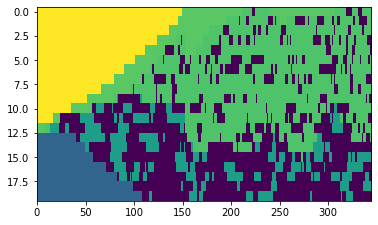

In [7]:
plt.imshow(np.log(hk)[:,10,:],interpolation='nearest')
plt.gca().set_aspect(10)

In [8]:



chd_data_orig = m.chd.stress_period_data
chd_data = {}
for per in range(m.dis.nper):
    chd_per=[]
    for val in chd_data_orig.data[0]:
        chd_per.append([val[0],val[1],val[2],DSA_head,DSA_head])
    chd_data[per] = chd_per
    
print('creating objs...')

lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=kvh, ipakcb=m.lpf.ipakcb,laytyp=0,laywet=0,
                              ss=m.lpf.ss.array,sy=m.lpf.sy.array)

try:
    sconc= m.btn.sconc.array
except:
    sconc= m.btn.sconc[0].array
btn = flopy.mt3d.Mt3dBtn(m,
                         laycon=m.btn.laycon.array, htop=m.btn.htop.array,
                         dz=m.dis.thickness.get_value(), prsity=prsity, icbund=m.btn.icbund.array,
                         sconc=sconc, nprs=1,timprs=m.btn.timprs)

dsp = flopy.mt3d.Mt3dDsp(m, al=aL,dmcoef=2.0e-9)
chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)


creating objs...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtbtn.Mt3dBtn'> <class 'flopy.mt3d.mtbtn.Mt3dBtn'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtdsp.Mt3dDsp'> <class 'flopy.mt3d.mtdsp.Mt3dDsp'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfchd.ModflowChd'> <class 'flopy.modflow.mfchd.ModflowChd'>
replacing existing Package...


In [10]:


writeyn= True
runyn = True
#Write input
if writeyn:
    print('writing...')
    m.write_input()
    
    
# Try to delete the output files, to prevent accidental use of older files
f_delete = [os.path.join(m.model_ws,'MT3D.CNF'),
            os.path.join(m.model_ws,'MT3D001.MAS'),
            os.path.join(m.model_ws, 'MT3D001.UCN'),
            os.path.join(m.model_ws, modelname + '.hds'),
            os.path.join(m.model_ws, modelname + '.cbc')]

for f in f_delete:
    try:
        os.remove(f)
    except:
        pass

#%%

if runyn:
    print('running...')
    v = m.run_model(silent=False, report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
else:
    print('Not running model!')

exportdir = outputdir.joinpath('NM')
if not exportdir.exists():
    exportdir.mkdir(parents=True)

date_per = starttime + np.cumsum(m.dis.perlen.array)/365
survey_date = 2017.25
survey_kper = np.argmin(np.abs(date_per-survey_date))

fname = os.path.join(m.model_ws, 'MT3D001.UCN')
totim = flopy.utils.binaryfile.UcnFile(fname).get_times()[-1]
try:
    conc_fname = 'conc{}_{}_totim{}_{}.UCN'.format(
        it, ts, str(int(totim)),job_id)
except:
    conc_fname = 'conc{}_{}_totim{}.UCN'.format(
        it, ts, str(int(totim)))

utils.copy_rename(fname,
                 exportdir.joinpath(conc_fname))
conc = flopy.utils.binaryfile.UcnFile(fname).get_data(kstpkper=(0,survey_kper))
np.save(exportdir.joinpath(conc_fname[:-4] + '.npy'),conc)

writing...
running...
FloPy is using the following  executable to run the model: /home/groups/rknight/swtv4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: NM.nam                                                                                                                                                                                                  
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/07/07 20:08:20


 STRESS PERIOD NO.  

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3635E-01  [K,I,J]    1    3  152
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6143E-03  [K,I,J]    3   19  162
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1619E-04  [K,I,J]    3   18  162
 Transport Step:   23   Step Size:   4.348     Total Elapsed Time:   78.914    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3533E-01  [K,I,J]    1    3  152
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5553E-03  [K,I,J]    3   19  162
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1477E-04  [K,I,J]    3   18  162
 Transport Step:   24   Step Size:   4.350     Total Elapsed Time:   83.264    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3407E-01  [K,I,J]    1    3  151
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5032E-03  [K,I,J]    3   19  162
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1350E-04  [K,I,J]    3   18  162
 Transport Step:   25   Step Size:   4.351     Total Elapsed Time:   87.615    
 Outer Iter.  1  Inner Iter.  1:  Max. D


  STRESS PERIOD    2 TIME STEP    1 FROM TIME =   182.50     TO    365.00    

 Transport Step:    1   Step Size:   4.371     Total Elapsed Time:   186.87    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3406E-01  [K,I,J]    9   17  113
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1098E-03  [K,I,J]    3   19  162
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4114E-05  [K,I,J]    3   19  162
 Transport Step:    2   Step Size:   4.207     Total Elapsed Time:   191.08    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1738E-01  [K,I,J]    1    7  149
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1016E-03  [K,I,J]    3   19  162
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3621E-05  [K,I,J]    3   19  162
 Transport Step:    3   Step Size:   4.144     Total Elapsed Time:   195.22    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1684E-01  [K,I,J]    1   11  151
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9174E-04  [K,I,J]    3   19  162
 Transport Step:    4   Step Size:   4.1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1091E-01  [K,I,J]    1   12  148
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6782E-04  [K,I,J]    1    9  149
 Transport Step:   35   Step Size:   4.119     Total Elapsed Time:   327.01    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1079E-01  [K,I,J]    1   15  149
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6589E-04  [K,I,J]    1    9  149
 Transport Step:   36   Step Size:   4.119     Total Elapsed Time:   331.13    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1066E-01  [K,I,J]    1   15  149
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6398E-04  [K,I,J]    1    9  149
 Transport Step:   37   Step Size:   4.119     Total Elapsed Time:   335.24    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1055E-01  [K,I,J]    1   13  148
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6209E-04  [K,I,J]    1    9  149
 Transport Step:   38   Step Size:   4.119     Total Elapsed Time:   339.36    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7818E-02  [K,I,J]    3    8  147
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2244E-04  [K,I,J]    1    9  149
 Transport Step:   24   Step Size:   4.042     Total Elapsed Time:   462.12    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7776E-02  [K,I,J]    3    8  147
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2173E-04  [K,I,J]    1    9  149
 Transport Step:   25   Step Size:   4.042     Total Elapsed Time:   466.17    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7730E-02  [K,I,J]    3    8  147
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2103E-04  [K,I,J]    1    9  149
 Transport Step:   26   Step Size:   4.042     Total Elapsed Time:   470.21    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7680E-02  [K,I,J]    3    8  147
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2036E-04  [K,I,J]    1    9  149
 Transport Step:   27   Step Size:   4.042     Total Elapsed Time:   474.25    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6353E-02  [K,I,J]    3   11  147
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2459E-04  [K,I,J]    2   17  200
 Transport Step:   12   Step Size:   4.041     Total Elapsed Time:   596.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6320E-02  [K,I,J]    3   11  147
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2444E-04  [K,I,J]    2   17  200
 Transport Step:   13   Step Size:   4.041     Total Elapsed Time:   600.04    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6284E-02  [K,I,J]    3   11  147
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2423E-04  [K,I,J]    2   17  200
 Transport Step:   14   Step Size:   4.041     Total Elapsed Time:   604.08    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6254E-02  [K,I,J]    3    8  146
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2398E-04  [K,I,J]    2   17  200
 Transport Step:   15   Step Size:   4.041     Total Elapsed Time:   608.12    
 Outer Iter.  1  Inner Iter.  1:  Max. D

KeyboardInterrupt: 